# Tutorial 1: Converting Audio Clip to Audio Representation Using BYOL-A

This tutorial explains how we can convert an arbitrary audio clip to an audio representation. You can find examples:

1. Load and convert an audio clip to a spectrogram.
2. Calculate statistics to normalize spectrograms.
3. Loading a BYOL-A model and pre-trained weight.
4. Encode spectrograms to representations.

### ⚠ Setup before you proceed ⚠

If you have not setup, run the commands in [Setup-commands.txt](../Setup-commands.txt).

---
### 0.1 Making the notebook work better

First, setup autoloading of this notebook. Thanks to https://github.com/ipython/ipython/issues/9732

In [1]:
import IPython

from IPython import get_ipython
ipython = get_ipython()
ipython.magic('reload_ext autoreload')
ipython.magic('autoreload 2')
ipython.magic('matplotlib inline')

### 0.2 Adding path and import modules

We append root folder and EVAR folder to the system `path`.

In [2]:
import sys
sys.path.extend(['..', '../evar'])

Import modules needed to run the followings.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torchaudio

---
## 1. Load and convert audio clips to spectrograms

We use two animal voices. Thanks to Toro, a Shiba-Inu, and Haru, a black cat.

<table style="background-color:#FFFFFF;">
  <tr>
    <td valign="top"><img src="shibainu-toro.jpg" width="250" /></td>
    <td valign="top"><img src="cat-haru.jpg" width="200" /></td>
  </tr>
  <tr>
    <td style="text-align: center;">Toro</td>
    <td style="text-align: center;">Haru</td>
  </tr>
 </table>
 
 ### 1.1 Load audios

In [4]:
files = ['barking-shibainu.wav', '563746_cat.wav']

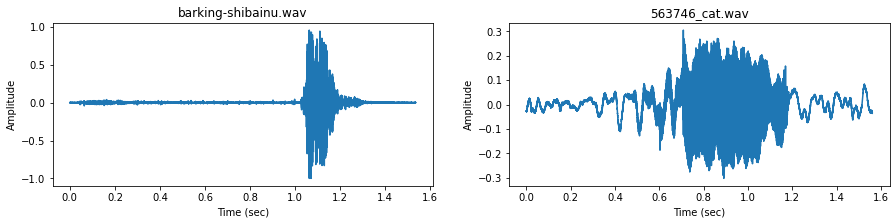

In [5]:
def load_sample_mono(file_name, display=True, subplot_idx=None):
    # loads audio in the shape of [channels, samples].
    wav, sr = torchaudio.load(file_name)
    # averages left and right channels into a single monoaural wave data.
    wav = wav.mean(0)

    if display:
        if subplot_idx:
            plt.subplot(subplot_idx)
        plt.plot(np.linspace(0.0, len(wav)/sr, len(wav)), wav)
        plt.xlabel('Time (sec)'); plt.ylabel('Amplitude');
        plt.title(file_name)
    return wav, sr

plt.figure(figsize=(15, 3))
wavs = []
wav, sr = load_sample_mono(files[0], subplot_idx=121)
assert sr == 44100, 'Make sure your audio is a 44.1kHz audio.'
wavs.append(wav)
wav, sr = load_sample_mono(files[1], subplot_idx=122)
assert sr == 44100, 'Make sure your audio is a 44.1kHz audio.'
wavs.append(wav)

In [6]:
from IPython.display import display, Audio

for wav in wavs:
    display(Audio(data=wav, rate=sr))

We loaded dog voice in `wavs[0]` and cat voice in `wavs[1]`.

### 1.2 Convert to spectrogram

The following converts raw audio into a log-mel spectrogram (LMS) and forms a batch of the two audios.

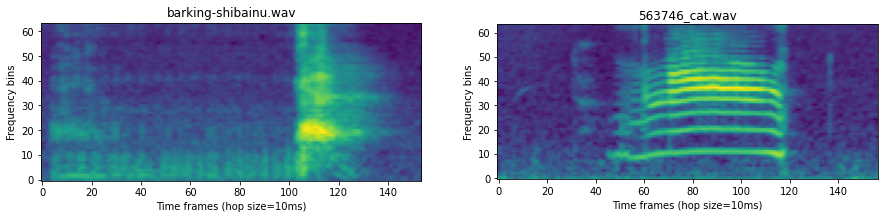

In [7]:
def wav_to_lms(wav, sr, display=True, subplot_idx=None):
    # convert to a log-mel spectrogram.
    X = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=2048, f_max=7800, f_min=60, n_mels=64,
            hop_length=sr//100)(wav).log() # 10ms

    if display:
        if subplot_idx:
            plt.subplot(subplot_idx)
        plt.imshow(X, origin='lower')
        plt.xlabel('Time frames (hop size=10ms)'); plt.ylabel('Frequency bins')
    return X

plt.figure(figsize=(15, 3))
X = []
for i in range(len(wavs)):
    x = wav_to_lms(wavs[i], sr, subplot_idx=121 + i)
    plt.title(files[i])
    X.append(x)

### Additional step: Trim data so that all the LMS has the same length

In the later steps, we handle log-mel spectrogram data with a deep learning model that can process a batch of input data, but all the inputs must be the same size in a batch.
To meet this requirement, we trim our data to make all have the same length.

In [8]:
# find shortest length
min_length = min([lms.shape[-1] for lms in X])

# trim
X = [lms[..., :min_length] for lms in X]

# convert to PyTorch tensor for making further process easy.
X = torch.stack(X)

print(X.shape) # [Batch size, Freq. bins, Time frames]

torch.Size([2, 64, 154])


In addition, we add one more channel axis because input data to a convolutional neural network model typically accept a shape of [B, C, F, T], and the C is 1 in our case. B, C, F, and T are batch size, channel, frequency bin, and time frame.

In [9]:
# [B, F, T] to [B, 1, F, T]
X = X.unsqueeze(1)

X.shape, X

(torch.Size([2, 1, 64, 154]),
 tensor([[[[-2.4352, -2.7768, -3.3347,  ..., -3.6911, -3.6525, -4.4448],
           [-3.1407, -2.5825, -2.8974,  ..., -3.1600, -3.1511, -4.4861],
           [-4.1881, -3.6489, -3.1057,  ..., -3.6523, -2.8505, -3.9025],
           ...,
           [-6.4466, -6.1356, -6.1466,  ..., -8.2455, -8.6427, -8.1583],
           [-5.7940, -5.6346, -5.9144,  ..., -8.0969, -8.1775, -8.0397],
           [-5.5089, -5.0263, -5.5033,  ..., -7.9007, -7.9078, -8.2867]]],
 
 
         [[[ 1.7296,  1.7802,  2.4861,  ...,  1.8022,  0.9257,  1.2386],
           [-0.8622, -0.4851,  0.7475,  ..., -0.1872, -1.6114, -1.1701],
           [-2.3449, -1.9506, -0.3596,  ..., -0.6788, -0.7098, -1.1418],
           ...,
           [-4.2078, -4.2770, -3.5427,  ..., -4.7978, -4.7308, -4.6067],
           [-3.7797, -4.2316, -4.0432,  ..., -4.5887, -4.6636, -5.0278],
           [-4.0263, -4.0596, -3.9154,  ..., -4.5681, -4.7662, -5.1104]]]]))

We converted both audios into log-mel spectrogram data in `X`.

## 2. Calculate statistics to normalize spectrograms.

The audio model BYOL-A we use in this tutorial needs inputs normalized to $N(0, 1)$.

We calculate mean and std statistics for normalization here.

In [10]:
norm_mean, norm_std = torch.mean(X), torch.std(X)

print('Mean is', norm_mean)
print('Standard deviation is', norm_std)

Mean is tensor(-2.5984)
Standard deviation is tensor(3.2347)


## 3. Loading a BYOL-A model and pre-trained weight

BYOL-A model has two classes available. One is for clip-level (or segment-level) representation, and another is for frame-level representation.

- AudioNTT2020 for clip-level (or segment-level) representation. Use this for applications such as classification (recognition).
- AudioNTT2020Task6 for frame-level representation. Use this for applications such as sound event detection.

### 3.1 AudioNTT2020 for clip-level (or segment-level) representation

In [11]:
from external.byol_a.byol_a.models import AudioNTT2020, AudioNTT2020Task6

# instantiate model.
clip_level_model = AudioNTT2020(n_mels=64, d=2048)

# evaluation mode.
clip_level_model.eval()

# load weights.
clip_level_model.load_state_dict(torch.load('../evar/external/byol_a/pretrained_weights/AudioNTT2020-BYOLA-64x96d2048.pth'))

<All keys matched successfully>

### 3.2 AudioNTT2020Task6 for frame-level representation



In [12]:
# instantiate model.
frame_level_model = AudioNTT2020Task6(n_mels=64, d=2048)

# evaluation mode.
frame_level_model.eval()

# load weights.
frame_level_model.load_state_dict(torch.load('../evar/external/byol_a/pretrained_weights/AudioNTT2020-BYOLA-64x96d2048.pth'))

<All keys matched successfully>

## 4. Encode spectrograms to representations.

In [13]:
# normalize batch
normalized_X = (X - norm_mean) / max(norm_std, 1e-12)

print('Mean and std of the normalized_X:', normalized_X.mean(), normalized_X.std())

Mean and std of the normalized_X: tensor(-2.7625e-08) tensor(1.0000)


### 4.1 Clip level feature representation

Clip level = entire audio clip.

Shape of features: torch.Size([2, 2048])


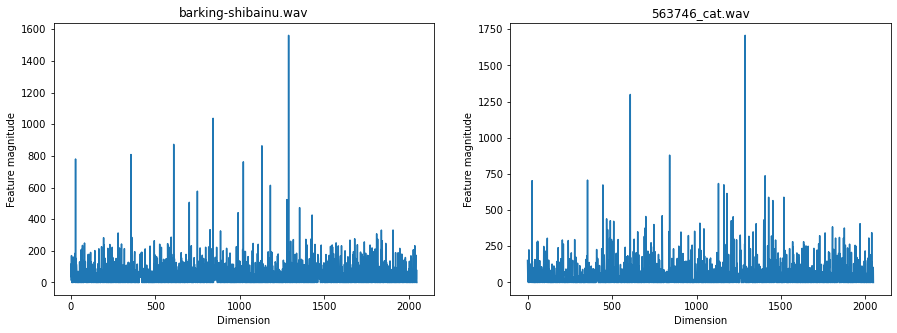

In [14]:
# encode 
features = clip_level_model(normalized_X).detach()
print('Shape of features:', features.shape)

def plot_feature(x, subplot_idx=None, ylim=None):
    if subplot_idx:
        plt.subplot(subplot_idx)
    plt.plot(x)
    if ylim:
        plt.ylim(ylim)
    plt.ylabel('Feature magnitude'); plt.xlabel('Dimension')

plt.figure(figsize=(15, 5))
for i in range(len(features)):
    plot_feature(features[i], subplot_idx=121 + i)
    plt.title(files[i])

### 4.2 (Time) Frame level feature representation

In [15]:
framed_features = frame_level_model(X).detach()

print('Shape of features:', framed_features.shape)

Shape of features: torch.Size([2, 19, 2048])


The feature is a shape of [Batch, Time frame, Feature dimension]. We visualize for each frame.

#### Why number of time frame is 19?

The original audio was about 1.5 seconds, which is 154 time-frames in the log-mel spectrogram.
The BYOL-A network has three convolutional blocks that halve the time frame in each block.

$19 = \text{int}(154 / 2 / 2/ 2)$

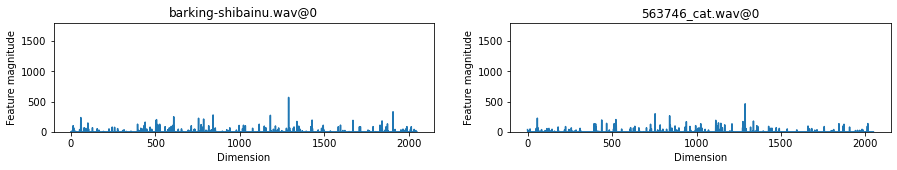

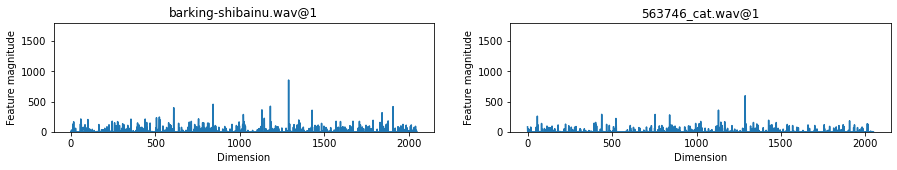

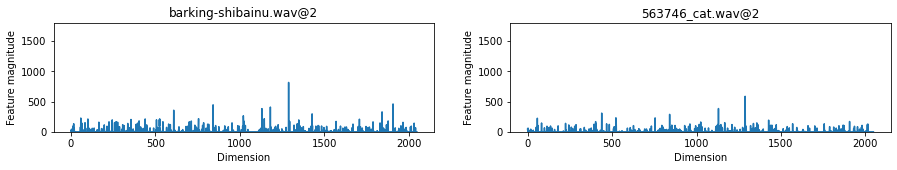

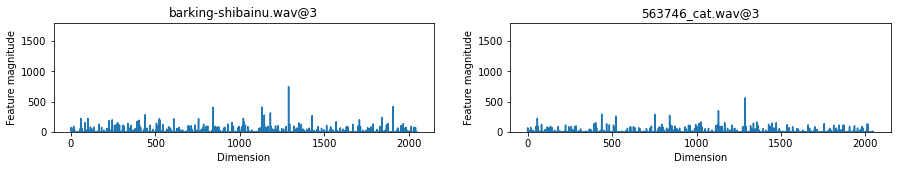

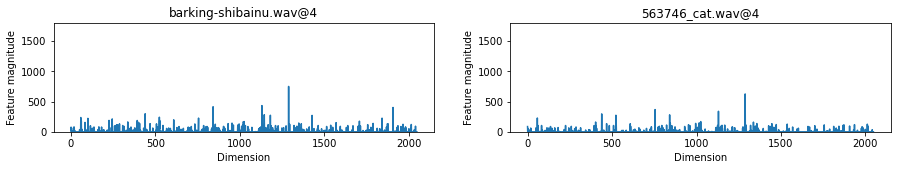

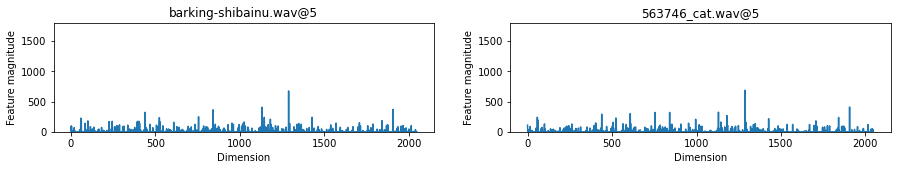

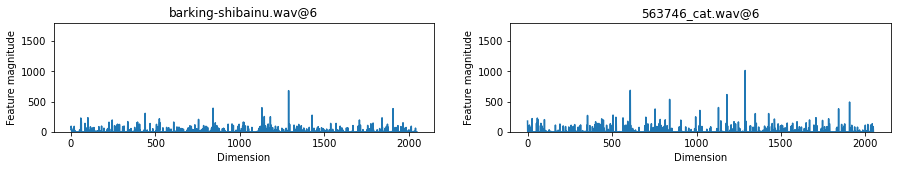

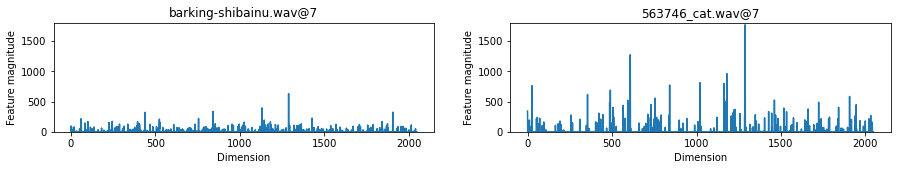

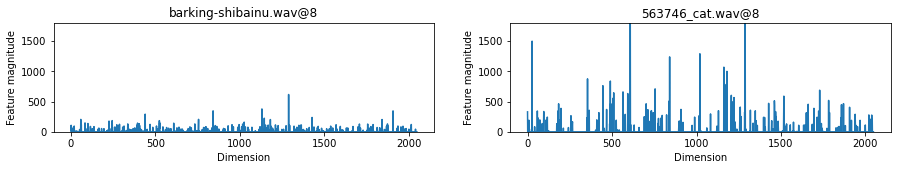

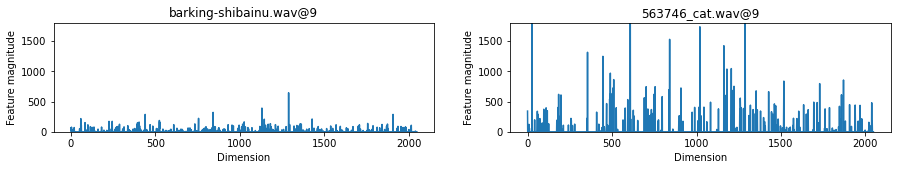

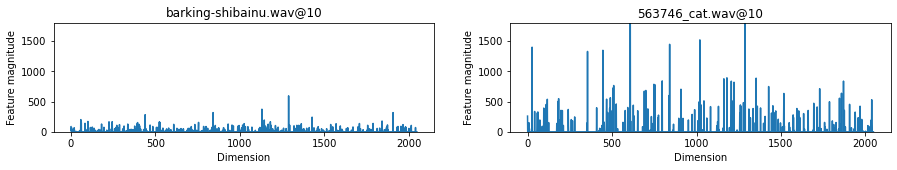

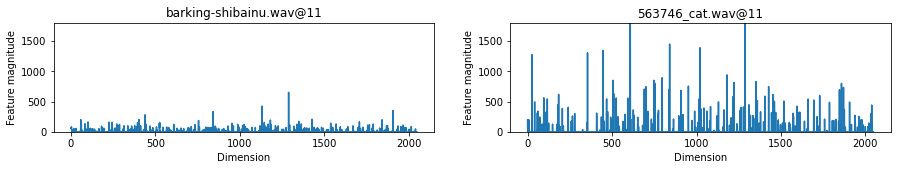

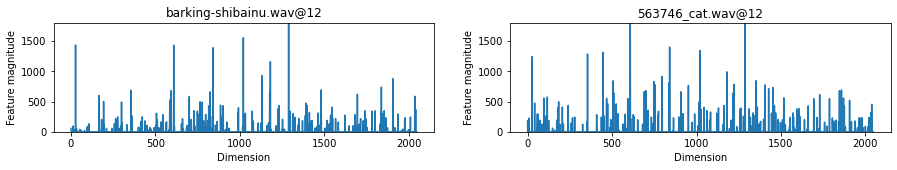

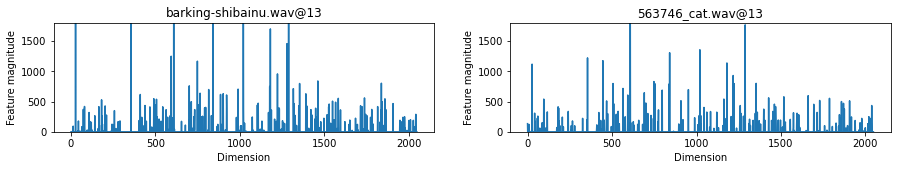

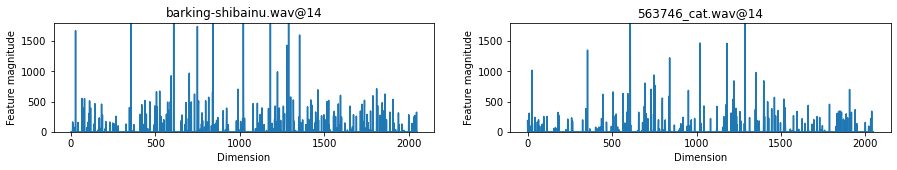

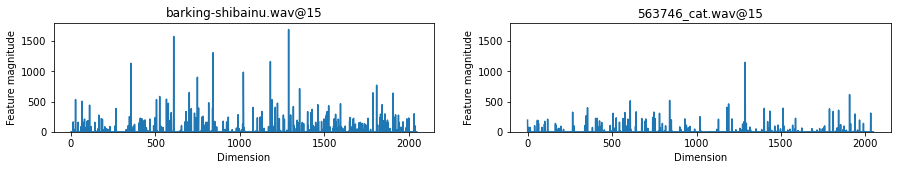

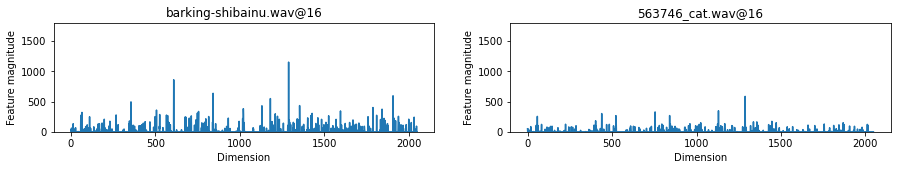

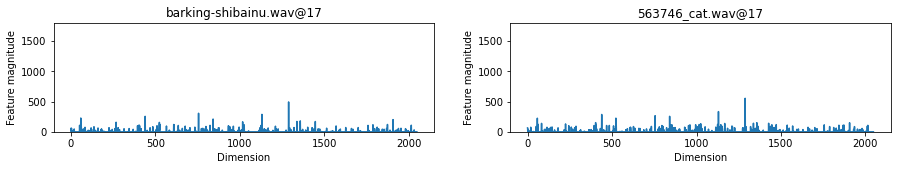

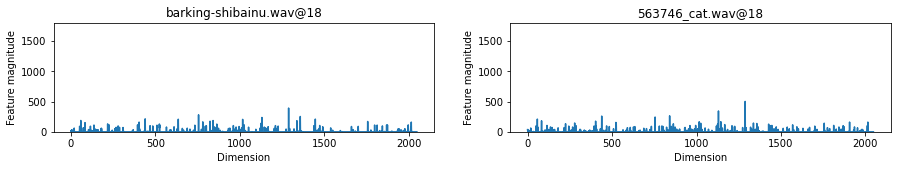

In [25]:
for t in range(framed_features.shape[1]):
    plt.figure(figsize=(15, 2))
    for i in range(framed_features.shape[0]):
        plot_feature(framed_features[i, t], subplot_idx=121 + i, ylim=(0, 1800))
        plt.title(files[i] + f'@{t}')
    plt.show()

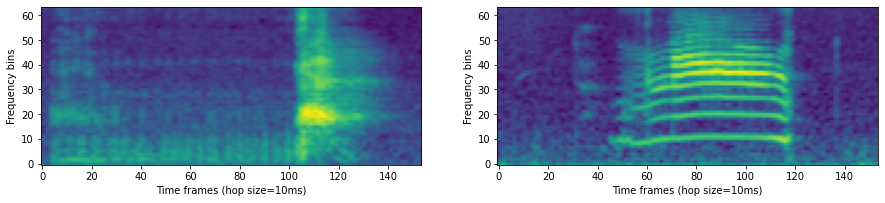

In [23]:
plt.figure(figsize=(15, 5))
for i in range(len(X)):
    plt.subplot(121 + i)
    plt.imshow(X[i, 0], origin='lower')
    plt.xlabel('Time frames (hop size=10ms)'); plt.ylabel('Frequency bins')